## Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [6]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import mne
from tinnsleep.config import Config
from tinnsleep.create_reports import preprocess, reporting
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import scipy
from tinnsleep.config import Config

print("config loaded")


config loaded


In [13]:
#Setting parameters
EDF_list = Config.bruxisme_files
os.chdir("C:/Users/Zeta/Documents/acou_sommeil_HD_ENS/Tinnitus-n-Sleep/Notebooks")
THR_classif=[[0,2], [0,3], [0,4], [0,5] , [0,6], [0,7], [0,8], [0,9], [0,10]]
sfreq = 200
window_length = 0.25                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping

#Importing personnalized parameters for dataset
df = pd.read_pickle("Resources/valid_chans_THR_imp")
dico_chans= df.to_dict("list")
print("parameters set")


parameters set


## Processing of the dataset and report generation

In [3]:
import warnings

#EDF_list=['E:/Acou_sommeil/EDF_V2_PAUL\\jon_mema.edf']

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    results={}
    print("Files processed : ")
    for filename in EDF_list:
        #opens the raw file
        raw = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
        print(filename.split("\\")[-1])
        #Get channels indexes
        ind_picks_chan= dico_chans[filename.split("\\")[-1]][0]
        ind_picks_imp= dico_chans[filename.split("\\")[-1]][1]
        #Get THR_imp value for filename
        THR_imp = dico_chans[filename.split("\\")[-1]][2]
        
        #Get channel names from indexes
        if len(ind_picks_chan)>0: #ignore file if no channel is good
            picks_chan=[]
            for elm in ind_picks_chan:
                picks_chan.append(raw.info["ch_names"][elm])
            picks_imp=[]
            for elm in ind_picks_imp:
                picks_imp.append(raw.info["ch_names"][elm])
            
            #Setting parameters for is_good
            params = dict(ch_names=picks_chan,
                  rejection_thresholds=dict(emg=1e-04),  # two order of magnitude higher q0.01
                  flat_thresholds=dict(emg=1e-09),  # one order of magnitude lower median
                  channel_type_idx=dict(emg=[ i for i in range(len(picks_chan))]),
                  full_report=True
                  )
            # Get the preprocessing steps done
            epochs, valid_labels, log = preprocess(raw, picks_chan, picks_imp, duration, interval, params, THR_imp=THR_imp, get_log=True)
            #If at least one epoch is good create report
            if np.sum(valid_labels)>0 : 
                results[filename] = reporting(epochs, valid_labels, THR_classif, log)
print("Reports created, process finished.")

Files processed : 
1BA07_nuit_hab.edf
1BA07_nuit_son.edf
1CC05_nuit_hab.edf
1CC05_nuit_son.edf
1DA15_nuit_hab.edf
1DA15_nuit_son.edf
1DL12_nuit_hab.edf
1DL12_nuit_son.edf
1GB18_nuit_son.edf
1GB19_nuit_hab.edf
1GF14_nuit_hab.edf
1GF14_nuit_son.edf
1MA16_nuit_hab.edf
1MA16_nuit_son.edf
1MF19_nuit_hab.edf
1MF19_nuit_son.edf
1MN09_nuit_hab.edf
1MN09_nuit_son.edf
1PI07_nuit_hab.edf
1PI07_nuit_son.edf
1PT06_nuit_hab.edf
1PT06_nuit_son.edf
1RA17_nuit_hab.edf
1RA17_nuit_son.edf
1SA14_nuit_hab.edf
1SA14_nuit_son.edf
1ZN04_nuit_hab.edf
1ZN04_nuit_son.edf
HZB_nuit_1.edf
HZB_nuit_2.edf
HZB_nuit_3.edf
SCHMIDTLIN_nuit_1_dec_OD__0to0.edf
SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf
SCHMIDTLIN_nuit_4_dec_OD__3to3.edf
SCHMIDTLIN_nuit_5_dec_OD__0to1.edf
SCHM_nuit_1.edf
SCHM_nuit_2.edf
SCHM_nuit_3.edf
Schmidtlin_nuit_2_dec_3to0to4.edf
Unger_2.edf
jon_mema.edf
jose_mema.edf
robin_mema_nuit_1.edf
robin_mema_nuit_2.edf
robin_nuit_23_sept.edf
robin_nuit_son_24_sept.edf
sophie_mema.edf
tom_mema.edf
unger_nuit_1.edf


## Saving results

In [4]:
df = pd.DataFrame.from_dict(results)
df.to_pickle("Resources/reports_and_datas_all")

## Data visualization for the entire cohort for nb episodes per hour as a function of THR_classif value : 

Text(0, 0.5, 'Nb of episodes per hour')

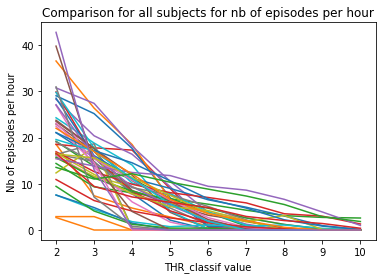

In [5]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Number of episodes per hour"])
    st = elm.split("\\")[-1] + " len " + str(ep["Clean data duration"])
    plt.plot([i+2 for i in range(9)], nb_ep)
plt.title('Comparison for all subjects for nb of episodes per hour')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')


## Data visualization for the entire cohort for nb bursts as a function of THR_classif value : 

Text(0, 0.5, 'Nb of burst on the recording')

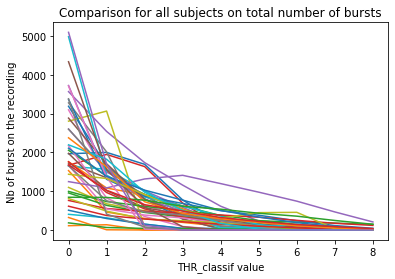

In [7]:
plt.figure()
for elm in results.keys():
    nb_ep=[]
    for ep in results[elm]["reports"]:
        nb_ep.append(ep["Total number of burst"])
    #print(f"Number of bursts for each THR_classif for {elm[-19:]} : {nb_ep}")
    st = elm.split("\\")[-1] + " len " + str(ep["Clean data duration"])
    plt.plot(nb_ep)
plt.title('Comparison for all subjects on total number of bursts')
plt.xlabel('THR_classif value')
plt.ylabel('Nb of burst on the recording')

## Logs of the preprocessing : 

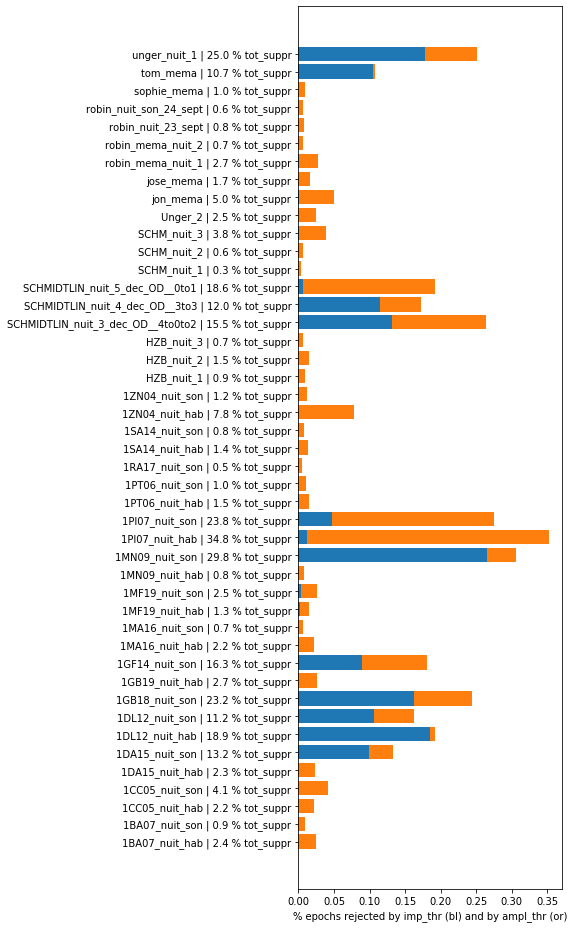

In [8]:
file=[]
suppr_imp=[]
suppr_amp=[]
for elm in results.keys():
    if results[elm]["log"]['suppressed_overall']/results[elm]["log"]['total_nb_epochs'] > 0.0001:
        file.append(elm.split("\\")[-1][:-4] + " | " + 
                    str("%.1f" % (100 *results[elm]["log"]['suppressed_overall']/results[elm]["log"]['total_nb_epochs']))
                   + " % tot_suppr")
        suppr_imp.append((results[elm]["log"]['suppressed_imp_THR']/results[elm]["log"]['total_nb_epochs']))
        suppr_amp.append(results[elm]["log"]['suppressed_amp_THR']/results[elm]["log"]['total_nb_epochs'])
       


fig, ax = plt.subplots(figsize=(8, 13))
rect1 = ax.barh(file, suppr_imp)
rect2 = ax.barh(file, suppr_amp, left=suppr_imp)
plt.xlabel("% epochs rejected by imp_thr (bl) and by ampl_thr (or)")
plt.tight_layout()
plt.show()


## Extracting list of nb of episodes per hour for all THR_classif per patient

In [9]:
get_scores=[]
for elm in results.keys():
        #print (elm)
        l_ep_h=[]
        for ep in results[elm]["reports"]:
            l_ep_h.append(ep["Number of episodes per hour"])

        get_scores.append([elm.split("\\")[-1], l_ep_h])
print(len(get_scores))
print(get_scores[-3:])

45
[['sophie_mema.edf', [13.565600600360856, 11.036420827412222, 12.186047996934327, 10.346644525698958, 8.85212920532022, 7.357613884941481, 5.518210413706111, 2.8740679238052658, 1.8394034712353702]], ['tom_mema.edf', [16.606639107215727, 9.453009953338183, 7.153629153877544, 6.003938754147224, 4.854248354416905, 2.9380976881997056, 2.0438940439650124, 1.405177155225946, 0.38323013324343985]], ['unger_nuit_1.edf', [42.80844323542578, 13.05740160462794, 0.3305671292310871, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]


## Getting masking volume data

In [10]:
get_pickle = pd.read_pickle("Resources/evolution_acous_nuits_masquage_v2_metaData_stats")
evol_masking = get_pickle["results"]

## Comparing nb_ep/hour between patients with tinnitus increase (augm) and without (stable) for values of THR_classif

Nb_patients in each group : 
Tinnitus increase : 11
Tinnitus stable : 17


Text(0, 0.5, 'Nb of episodes per hour')

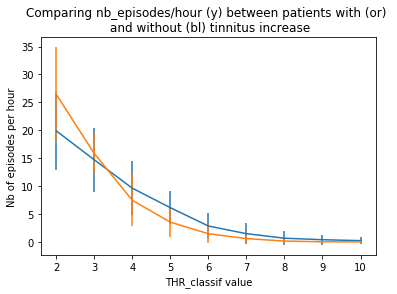

In [11]:
# Files not to consider for analysis
to_suppress=["Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf",
             "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf","1MA16_nuit_hab.edf","SCHM_nuit_1.edf",
             "HZB_nuit_3.edf"]
#Jutification : "Schmidtlin_nuit_2_dec_3to0to4.edf", "SCHMIDTLIN_nuit_1_dec_OD__0to0.edf", 
# "SCHMIDTLIN_nuit_3_dec_OD__4to0to2.edf" : compromised data
# 1MA16_nuit_hab : patient awake all night
# HZB_nuit_3.edf partial night 

#Preparing values for correlation scatter plots
scat=[[] for i in range(len(THR_classif))]  #scatter plots with absolute values
pourc_scat=[[] for i in range(len(THR_classif))]  #scatter plots with percentages values


augm=[[] for i in range(len(THR_classif))]  #patients with tinnitus increase
stable=[[] for i in range(len(THR_classif))] #patients with stable or decreasing tinnitus
for elm in evol_masking:
    for i in range(len(get_scores)):
     if not to_suppress.__contains__(elm[0]):
        if elm[0]==get_scores[i][0]:
            
            #For correlation scatter plots
            for j in range(len(THR_classif)):
                #getting points [abs evolution masking volume ; coreesponding nb_episode/hour]
                scat[j].append([elm[-2], get_scores[i][1][j]])
                if elm[-1] < 1 :  # removing a strong outlier
                    #getting points [% evolution masking volume ; coreesponding nb_episode/hour]
                    pourc_scat[j].append([elm[-1], get_scores[i][1][j]])
            
            #Sorting patients according to tinnitus evolution overnight
            if (elm[2]>0):
                for j in range(len(THR_classif)):
                    augm[j].append(get_scores[i][1][j])
            else:
                for j in range(len(THR_classif)):
                    stable[j].append(get_scores[i][1][j])
                    
#Calculating mean and standard deviation for all THR_classif values
augm_m=[]
augm_std=[]
stable_m=[]
stable_std=[]
for elm in augm:
    augm_m.append(np.mean(elm))
    augm_std.append(np.std(elm))
for elm in stable:
    stable_m.append(np.mean(elm))
    stable_std.append(np.std(elm))
    
print("Nb_patients in each group : ")
print("Tinnitus increase : " + str(len(augm[0])))
print("Tinnitus stable : " + str(len(stable[0])))
    
#Displaying
plt.figure()
plt.errorbar([i+2 for i in range(len(THR_classif))],stable_m, stable_std)
plt.errorbar([i+2 for i in range(len(THR_classif))], augm_m, augm_std)
plt.title("Comparing nb_episodes/hour (y) between patients with (or) \n and without (bl) tinnitus increase" )
plt.xlabel('THR_classif value')
plt.ylabel('Nb of episodes per hour')

## Displaying correlation plots for absolute overnight evolutions of tinnitus

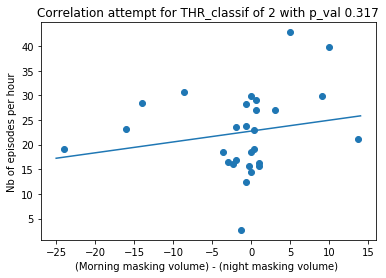

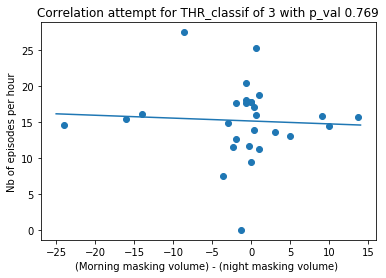

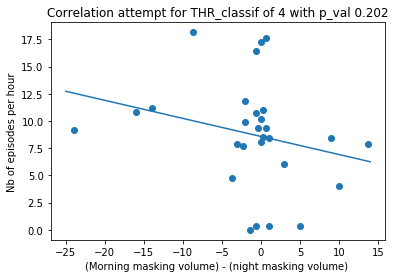

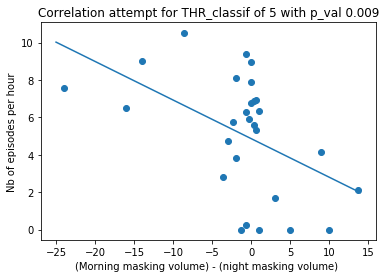

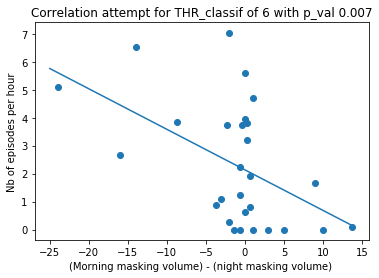

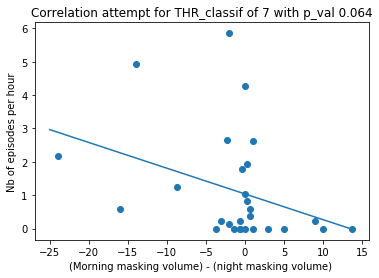

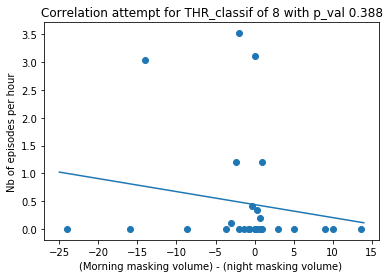

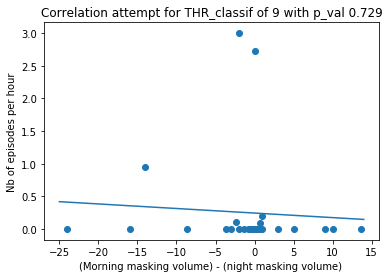

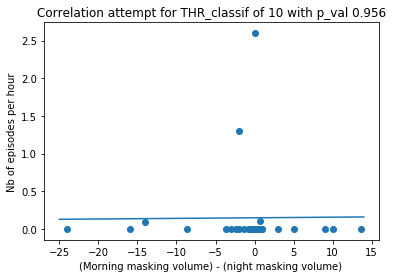

In [15]:
for j in range(len(THR_classif)):  
    tab = np.asanyarray(scat[j])
    tab = tab.transpose()
    #print(j+2)
    
    regre = scipy.stats.linregress(tab[0],tab[1])
    #print(regre)
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-25 for i in range(40)],[intercept + slope *(i-25) for i in range(40)])
    #plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning masking volume) - (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')

## Displaying correlation plots for percentage overnight evolutions of tinnitus

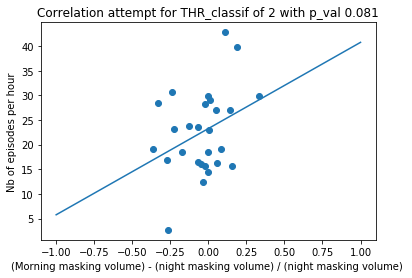

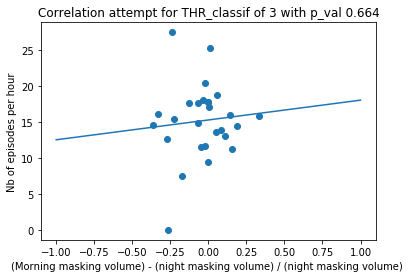

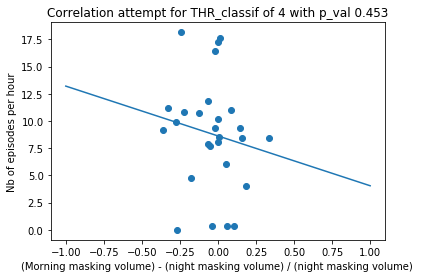

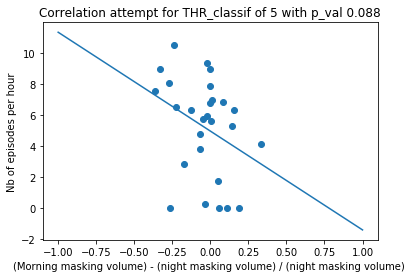

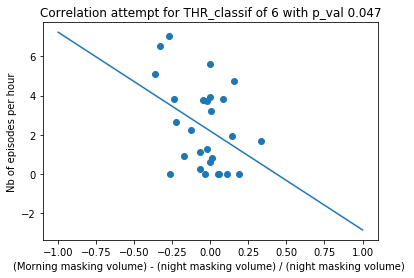

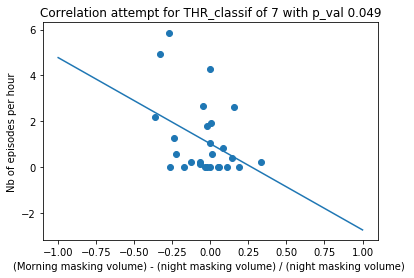

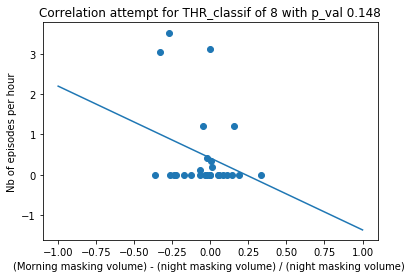

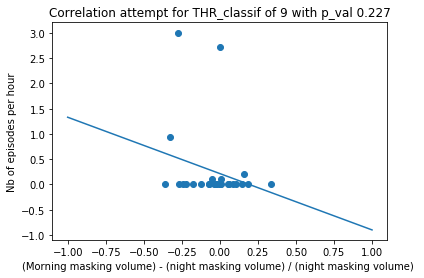

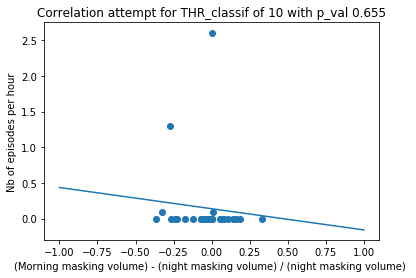

In [16]:
for j in range(len(THR_classif)):
    tab = np.asanyarray(pourc_scat[j])
    tab = tab.transpose()
    regre = scipy.stats.linregress(tab[0],tab[1])
    slope=regre[0]
    intercept = regre[1]
    plt.figure()
    plt.scatter(tab[0], tab[1])
    plt.plot([i-1 for i in range(3)],[intercept + slope *(i-1) for i in range(3)])
    plt.title("Correlation attempt for THR_classif of " + str(j+2) + " with p_val "+ str("%.3f" % regre[3]))
    plt.xlabel('(Morning masking volume) - (night masking volume) / (night masking volume) ')
    plt.ylabel('Nb of episodes per hour')